In [1]:
%config Completer.use_jedi = False

In [5]:
import numpy as np

In [3]:
import parametrized_tokamak_source as pts

In [6]:
from parametrized_tokamak_source.plot_tokamak_source import scatter_tokamak_source, plot_tokamak_source_3D

<Axes: >

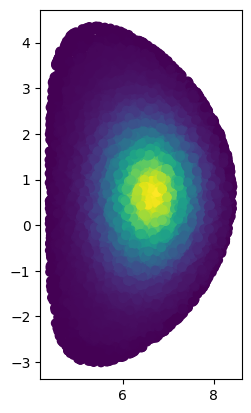

In [8]:
my_plasma = pts.ParametrizedTokamakSource(sample_size=10000)
scatter_tokamak_source(my_plasma, quantity='strength', aspect='equal')

<Axes3D: >

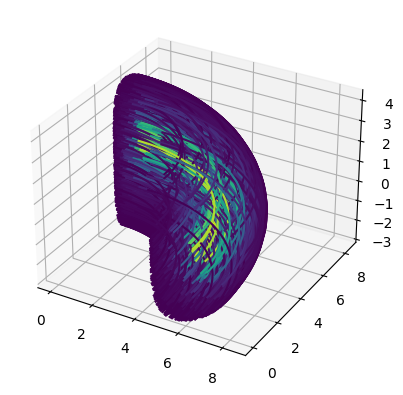

In [11]:
plot_tokamak_source_3D(my_plasma, quantity='strength', angles=[0, 0.5 * np.pi])

In [9]:
import openmc
# Create a single material
iron = openmc.Material()
iron.set_density("g/cm3", 5.0)
iron.add_element("Fe", 1.0)
mats = openmc.Materials([iron])

# Create a 5 cm x 5 cm box filled with iron
cells = []
inner_box1 = openmc.ZCylinder(r=600.0)
inner_box2 = openmc.ZCylinder(r=1400.0)
outer_box = openmc.model.rectangular_prism(4000.0, 4000.0, boundary_type="vacuum")
cells += [openmc.Cell(fill=iron, region=-inner_box1)]
cells += [openmc.Cell(fill=None, region=+inner_box1 & -inner_box2)]
cells += [openmc.Cell(fill=iron, region=+inner_box2 & outer_box)]
geometry = openmc.Geometry(cells)

# Tell OpenMC we're going to use our custom source
settings = openmc.Settings()
settings.run_mode = "fixed source"
settings.batches = 10
settings.particles = 10000
settings.source = my_plasma.sources

# Finally, define a mesh tally so that we can see the resulting flux
mesh = openmc.RegularMesh()
mesh.lower_left = (-2000.0, -2000.0)
mesh.upper_right = (2000.0, 2000.0)
mesh.dimension = (4000, 4000)

tally = openmc.Tally()
tally.filters = [openmc.MeshFilter(mesh)]
tally.scores = ["flux"]
tallies = openmc.Tallies([tally])

model = openmc.model.Model(
    materials=mats, geometry=geometry, settings=settings, tallies=tallies
)

settings.export_to_xml()
#model.run(tracks=True)

/home/dvp/dev/openmc/openmc/model/funcs.py:114: FutureWarning: The rectangular_prism(...) function has been replaced by the RectangularPrism(...) class. Future versions of OpenMC will not accept rectangular_prism.
  warn("The rectangular_prism(...) function has been replaced by the "


In [10]:
sp = openmc.StatePoint('statepoint.10.h5')
tallies = sp.get_tally(scores=['flux'])
df = tallies.get_pandas_dataframe()
df_flux = df.loc[df['score'] == 'flux']

mesh.write_data_to_vtk('mesh_data_flux_normalized.vtk', {'flux': df_flux['mean'].values}, volume_normalization=False)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'statepoint.10.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)